# Estimating Equilibrium Climate Sensitivity (ECS) in CMIP6 models

**Authors:** [Henry Drake](https://eapsweb.mit.edu/people/hdrake) and [Ryan Abernathey](https://ocean-transport.github.io/)

**Adapted from** https://github.com/hdrake/cmip6-temperature-demo/blob/master/notebooks/01_calculate_ECS_Gregory_method.ipynb 

---

*Definition:* Equilibrium Climate Sensitivity is defined as change in global-mean near-surface air temperature (GMST) change due to an instantaneous doubling of CO$_{2}$ concentrations and once the coupled ocean-atmosphere-sea ice system has acheived a statistical equilibrium (i.e. at the top-of-atmosphere, incoming solar shortwave radiation is balanced by reflected solar shortwave and outgoing thermal longwave radiation).

This notebook uses the ["Gregory method"](https://agupubs.onlinelibrary.wiley.com/doi/epdf/10.1029/2003GL018747) to approximate the ECS of CMIP6 models based on the first 150 years after an abrupt quadrupling of CO$_{2}$ concentrations. The "Gregory Method" extrapolates the quasi-linear relationship between GMST and radiative imbalance at the top-of-atmosphere to estimate how much warming would occur if the system were in radiative balance at the top-of-atmosphere, which is by definition the equilibrium response. In particular, we extrapolate the linear relationship that occurs between 100 and 150 years after the abrupt quadrupling. Since the radiative forcing due to CO$_{2}$ is a logarithmic function of the CO$_{2}$ concentration, the GMST change from a first doubling is roughly the same as for a second doubling (to first order, we can assume feedbacks as constant), which means that the GMST change due to a quadrupling of CO$_{2}$ is roughly $\Delta T_{4 \times \text{CO}_{2}} = 2 \times \text{ECS}$. See also [Mauritsen et al. 2019](https://agupubs.onlinelibrary.wiley.com/doi/epdf/10.1029/2018MS001400) for a detailed application of the Gregory Method (with modifications) for the case of one specific CMIP6 model, the MPI-M Earth System Model.

For another take on applying the Gregory method to estimate ECS, see [Angeline Pendergrass' code](https://github.com/apendergrass/cmip6-ecs).

### Python packages

In [1]:
import cartopy
import dask
import fsspec
import intake
import numpy as np
import pandas as pd
import xarray as xr
import xesmf as xe
from matplotlib import pyplot as plt
from tqdm.autonotebook import tqdm  # Fancy progress bars for our loops!

%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 6
%config InlineBackend.figure_format = 'retina'

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  


### Compute Cluster

Here we use a dask cluster to parallelize our analysis. The cluster scales up and down adaptively.

In [2]:
from dask.distributed import Client
from dask_gateway import Gateway

gateway = Gateway()
cluster = gateway.new_cluster()
cluster.adapt(minimum=1, maximum=20)
client = Client(cluster)
cluster

## Data catalogs

This notebook uses [`intake-esm`](https://intake-esm.readthedocs.io/en/latest/) to ingest and organize climate model output from the fresh-off-the-supercomputers Phase 6 of the Coupled Model Intercomparison Project (CMIP6). 

The file `https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv` in google cloud storage contains thousands of lines of metadata, each describing an individual climate model experiment's simulated data.

For example, the first line in the csv file contains the precipitation rate (`variable_id = 'pr'`), as a function of latitude, longitude, and time, in an individual climate model experiment with the BCC-ESM1 model (`source_id = 'BCC-ESM1'`) developed by the Beijing Climate Center (`institution_id = 'BCC'`). The model is *forced* by the forcing experiment SSP370 (`experiment_id = 'ssp370'`), which stands for the Shared Socio-Economic Pathway 3 that results in a change in radiative forcing of $\Delta F = 7.0$ W/m$^{2}$ from pre-industrial to 2100. This simulation was run as part of the `AerChemMIP` activity, which is a spin-off of the CMIP activity that focuses specifically on how aerosol chemistry affects climate.

In [3]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df.head()

/srv/conda/envs/notebook/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,AerChemMIP,AS-RCEC,TaiESM1,histSST,r1i1p1f1,AERmon,od550aer,gn,gs://cmip6/AerChemMIP/AS-RCEC/TaiESM1/histSST/...,NaN,20200310
1,AerChemMIP,BCC,BCC-ESM1,histSST,r1i1p1f1,AERmon,mmrbc,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/histSST/r1i...,NaN,20190718
2,AerChemMIP,BCC,BCC-ESM1,histSST,r1i1p1f1,AERmon,mmrdust,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/histSST/r1i...,NaN,20191127
3,AerChemMIP,BCC,BCC-ESM1,histSST,r1i1p1f1,AERmon,mmroa,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/histSST/r1i...,NaN,20190809
4,AerChemMIP,BCC,BCC-ESM1,histSST,r1i1p1f1,AERmon,mmrso4,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/histSST/r1i...,NaN,20191127


The file `pangeo-cmip6.json` describes the structure of the CMIP6 metadata and is formatted so as to be read in by the `intake.open_esm_datastore` method, which categorizes all of the data pointers into a tiered collection. For example, this collection contains the simulated data from 28691 individual experiments, representing 48 different models from 23 different scientific institutions. There are 190 different climate variables (e.g. sea surface temperature, sea ice concentration, atmospheric winds, dissolved organic carbon in the ocean, etc.) available for 29 different forcing experiments.

### Use Intake ESM

[Intake-esm](https://intake-esm.readthedocs.io/) is a new package designed to make working with these data archives a bit simpler.

In [4]:
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")
col

/srv/conda/envs/notebook/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3417: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,unique
activity_id,15
institution_id,34
source_id,79
experiment_id,107
member_id,213
table_id,30
variable_id,392
grid_label,10
zstore,294376
dcpp_init_year,60


Here, we show the various forcing experiments that climate modellers ran in these simulations.

In [5]:
df['experiment_id'].unique()

array(['histSST', 'piClim-CH4', 'piClim-NTCF', 'piClim-control', 'ssp370',
       'hist-1950HC', 'piClim-2xDMS', 'piClim-2xdust', 'piClim-2xfire',
       'piClim-2xss', 'piClim-BC', 'piClim-HC', 'piClim-N2O', 'piClim-OC',
       'piClim-SO2', 'piClim-aer', '1pctCO2-bgc', '1pctCO2-rad',
       'esm-ssp585', 'hist-bgc', 'amip-4xCO2', 'amip-future4K',
       'amip-m4K', 'amip-p4K', 'amip', 'abrupt-2xCO2', 'abrupt-solp4p',
       'abrupt-0p5xCO2', 'amip-lwoff', 'amip-p4K-lwoff', 'aqua-4xCO2',
       'abrupt-solm4p', 'aqua-control-lwoff', 'aqua-control',
       'aqua-p4K-lwoff', 'aqua-p4K', '1pctCO2', 'abrupt-4xCO2',
       'historical', 'piControl', 'esm-hist', 'esm-piControl', 'ssp126',
       'ssp245', 'ssp585', 'esm-piControl-spinup', 'piControl-spinup',
       'hist-GHG', 'hist-aer', 'hist-nat', 'hist-CO2', 'hist-sol',
       'hist-stratO3', 'hist-volc', 'ssp245-GHG', 'ssp245-aer',
       'ssp245-nat', 'ssp245-stratO3', 'dcppA-hindcast', 'dcppA-assim',
       'dcppC-hindcast-noAgung', 

## Analysis of Climate Model Output Data

### Loading data

[intake-esm](https://intake-esm.readthedocs.io/) enables loading data directly into an [xarray.DataArray](http://xarray.pydata.org/en/stable/api.html#dataset), a metadata-aware extension of numpy arrays. `xarray` objects leverage [dask](https://dask.org/) to only read data into memory as needed for any specific operation (i.e. lazy evaluation). Think of `xarray` Datasets as ways of conveniently organizing large arrays of floating point numbers (e.g. climate model data) on an n-dimensional discrete grid, with important metadata such as units, variable, names, etc.

Note that data on the cloud are in [zarr](https://zarr.readthedocs.io/en/stable/) format, an extension of the metadata-aware format [netcdf](https://www.unidata.ucar.edu/software/netcdf/) commonly used in geosciences.

`intake-esm` has rules for aggegating datasets; these rules are defined in the collection-specification file.

#### Choice of simulated forcing experiments

Here, we choose the `piControl` experiment (in which CO2 concentrations are held fixed at a pre-industrial level of ~300 ppm) and `abrupt-4xCO2` experiment (in which CO2 concentrations are instantaneously quadrupled - or doubled twice - from a pre-industrial controrl state). Since the radiative forcing of CO2 is roughly a logarithmic function of CO2 concentrations, the ECS is roughly independent of the initial CO2 concentration. Thus, if one doubling of CO2 results in $ECS$ of warming, then two doublings (or, a quadrupling) results in $2 \times ECS$ of warming.

Ideally, we would choose the `abrupt-2xCO2` forcing experiment, but more 4xCO2 data are currently avaiable in Google Cloud Storage, making for a better example.

### Prepare Data

In [6]:
query = dict(
    experiment_id=[
        'abrupt-4xCO2',
        'piControl',
    ],  # pick the `abrupt-4xCO2` and `piControl` forcing experiments
    table_id='Amon',  # choose to look at atmospheric variables (A) saved at monthly resolution (mon)
    variable_id=[
        'tas',
        'rsut',
        'rsdt',
        'rlut',
    ],  # choose to look at near-surface air temperature (tas) as our variable
    member_id='r1i1p1f1',  # arbitrarily pick one realization for each model (i.e. just one set of initial conditions)
)

col_subset = col.search(require_all_on=["source_id"], **query)
col_subset.df.groupby("source_id")[["experiment_id", "variable_id", "table_id"]].nunique()

,experiment_id,variable_id,table_id
source_id,,,
ACCESS-CM2,2,4,1
ACCESS-ESM1-5,2,4,1
AWI-CM-1-1-MR,2,4,1
BCC-CSM2-MR,2,4,1
BCC-ESM1,2,4,1
CAMS-CSM1-0,2,4,1
CESM2,2,4,1
CESM2-WACCM,2,4,1
CanESM5,2,4,1


The following functions help us load and homogenize the data.
We use some [dask.delayed](https://docs.dask.org/en/latest/delayed.html) programming to open the datasets in parallel.

In [7]:
def drop_all_bounds(ds):
    """Drop coordinates like 'time_bounds' from datasets,
    which can lead to issues when merging."""
    drop_vars = [vname for vname in ds.coords if (('_bounds') in vname) or ('_bnds') in vname]
    return ds.drop(drop_vars)


def open_dsets(df):
    """Open datasets from cloud storage and return xarray dataset."""
    dsets = [
        xr.open_zarr(fsspec.get_mapper(ds_url), consolidated=True).pipe(drop_all_bounds)
        for ds_url in df.zstore
    ]
    try:
        ds = xr.merge(dsets, join='exact')
        return ds
    except ValueError:
        return None


def open_delayed(df):
    """A dask.delayed wrapper around `open_dsets`.
    Allows us to open many datasets in parallel."""
    return dask.delayed(open_dsets)(df)

Create a nested dictionary of models and experiments. It will be structured like this:

    {'CESM2':
      {
        'piControl': <xarray.Dataset>,
        'abrupt-4xCO2': <xarray.Dataset>
      },
      ...
    }

In [8]:
from collections import defaultdict

dsets = defaultdict(dict)
for group, df in col_subset.df.groupby(by=['source_id', 'experiment_id']):
    dsets[group[0]][group[1]] = open_delayed(df)

Open one of the datasets directly, just to show what it looks like:

In [9]:
%time open_dsets(df)

CPU times: user 876 ms, sys: 72.2 ms, total: 948 ms
Wall time: 1.54 s


<xarray.Dataset>
Dimensions:  (lat: 192, lon: 288, time: 8400)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 0001-01-16 12:00:00 ... 0700-12-16 12:00:00
    height   float64 ...
Data variables:
    rlut     (time, lat, lon) float32 dask.array<chunksize=(600, 192, 288), meta=np.ndarray>
    rsdt     (time, lat, lon) float32 dask.array<chunksize=(600, 192, 288), meta=np.ndarray>
    rsut     (time, lat, lon) float32 dask.array<chunksize=(600, 192, 288), meta=np.ndarray>
    tas      (time, lat, lon) float32 dask.array<chunksize=(600, 192, 288), meta=np.ndarray>

Now use dask to do this in parallel on all of the datasets:

In [10]:
dsets_ = dask.compute(dict(dsets))[0]

### Reduce Data via Global Mean

We don't want to load all of the raw model data into memory right away. Instead, we want to reduce the data by taking the global mean. We need to remember to weight this global mean by a factor proportional to `cos(lat)`.

In [11]:
def get_lat_name(ds):
    """Figure out what is the latitude coordinate for each dataset."""
    for lat_name in ['lat', 'latitude']:
        if lat_name in ds.coords:
            return lat_name
    raise RuntimeError("Couldn't find a latitude coordinate")


def global_mean(ds):
    """Return global mean of a whole dataset."""
    lat = ds[get_lat_name(ds)]
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    other_dims = set(ds.dims) - {'time'}
    return (ds * weight).mean(other_dims)

We now apply this function, plus resampling to annual mean data, to all of the datasets.
We also concatenate the experiments together into a single Dataset for each model.
This is the most complex cell in the notebook. A lot is happening here.

In [12]:
expts = ['piControl', 'abrupt-4xCO2']
expt_da = xr.DataArray(expts, dims='experiment_id', coords={'experiment_id': expts})

dsets_aligned = {}

for k, v in tqdm(dsets_.items()):
    expt_dsets = v.values()
    if any([d is None for d in expt_dsets]):
        print(f"Missing experiment for {k}")
        continue

    for ds in expt_dsets:
        ds.coords['year'] = ds.time.dt.year - ds.time.dt.year[0]

    # workaround for
    # https://github.com/pydata/xarray/issues/2237#issuecomment-620961663
    dsets_ann_mean = [
        v[expt].pipe(global_mean).swap_dims({'time': 'year'}).drop('time').coarsen(year=12).mean()
        for expt in expts
    ]

    # align everything with the 4xCO2 experiment
    dsets_aligned[k] = xr.concat(dsets_ann_mean, join='right', dim=expt_da)

Missing experiment for EC-Earth3-Veg


Missing experiment for IPSL-CM6A-LR
Missing experiment for KACE-1-0-G


Missing experiment for NESM3


### Do the Computation

Up to this point, no computations have actually happened. Everything has been "lazy". Now we trigger the computation to actual occur and load the global / annual mean data into memory.

In [13]:
dsets_aligned_ = dask.compute(dsets_aligned)[0]

Now we concatenate across models to produce one big dataset with all the required variables.

In [14]:
source_ids = list(dsets_aligned_.keys())
source_da = xr.DataArray(source_ids, dims='source_id', coords={'source_id': source_ids})

big_ds = xr.concat([ds.reset_coords(drop=True) for ds in dsets_aligned_.values()], dim=source_da)
big_ds

<xarray.Dataset>
Dimensions:        (experiment_id: 2, source_id: 24, year: 999)
Coordinates:
  * source_id      (source_id) object 'ACCESS-CM2' ... 'SAM0-UNICON'
  * year           (year) float64 0.0 1.0 2.0 3.0 ... 995.0 996.0 997.0 998.0
  * experiment_id  (experiment_id) object 'piControl' 'abrupt-4xCO2'
Data variables:
    rlut           (source_id, experiment_id, year) float64 242.2 242.0 ... nan
    rsdt           (source_id, experiment_id, year) float64 340.4 340.4 ... nan
    rsut           (source_id, experiment_id, year) float64 97.84 97.84 ... nan
    tas            (source_id, experiment_id, year) float64 287.0 287.0 ... nan
    None           (source_id) <U13 'ACCESS-CM2' ... 'SAM0-UNICON'

### Calculated Derived Variables

We need to calculate the net radiative imbalance, plus the anomaly of the abrupt 4xCO2 run compared to the piControl run.

In [15]:
big_ds['imbalance'] = big_ds['rsdt'] - big_ds['rsut'] - big_ds['rlut']

ds_mean = big_ds[['tas', 'imbalance']].sel(experiment_id='piControl').mean(dim='year')
ds_anom = big_ds[['tas', 'imbalance']] - ds_mean

# add some metadata
ds_anom.tas.attrs['long_name'] = 'Global Mean Surface Temp Anom'
ds_anom.tas.attrs['units'] = 'K'
ds_anom.imbalance.attrs['long_name'] = 'Global Mean Radiative Imbalance'
ds_anom.imbalance.attrs['units'] = 'W m$^{-2}$'

ds_anom

<xarray.Dataset>
Dimensions:        (experiment_id: 2, source_id: 24, year: 999)
Coordinates:
  * source_id      (source_id) object 'ACCESS-CM2' ... 'SAM0-UNICON'
  * year           (year) float64 0.0 1.0 2.0 3.0 ... 995.0 996.0 997.0 998.0
  * experiment_id  (experiment_id) object 'piControl' 'abrupt-4xCO2'
Data variables:
    tas            (source_id, experiment_id, year) float64 -0.03737 ... nan
    imbalance      (source_id, experiment_id, year) float64 -0.04809 ... nan

### Plot Timeseries

Here we plot the global mean surface temperature for each model:

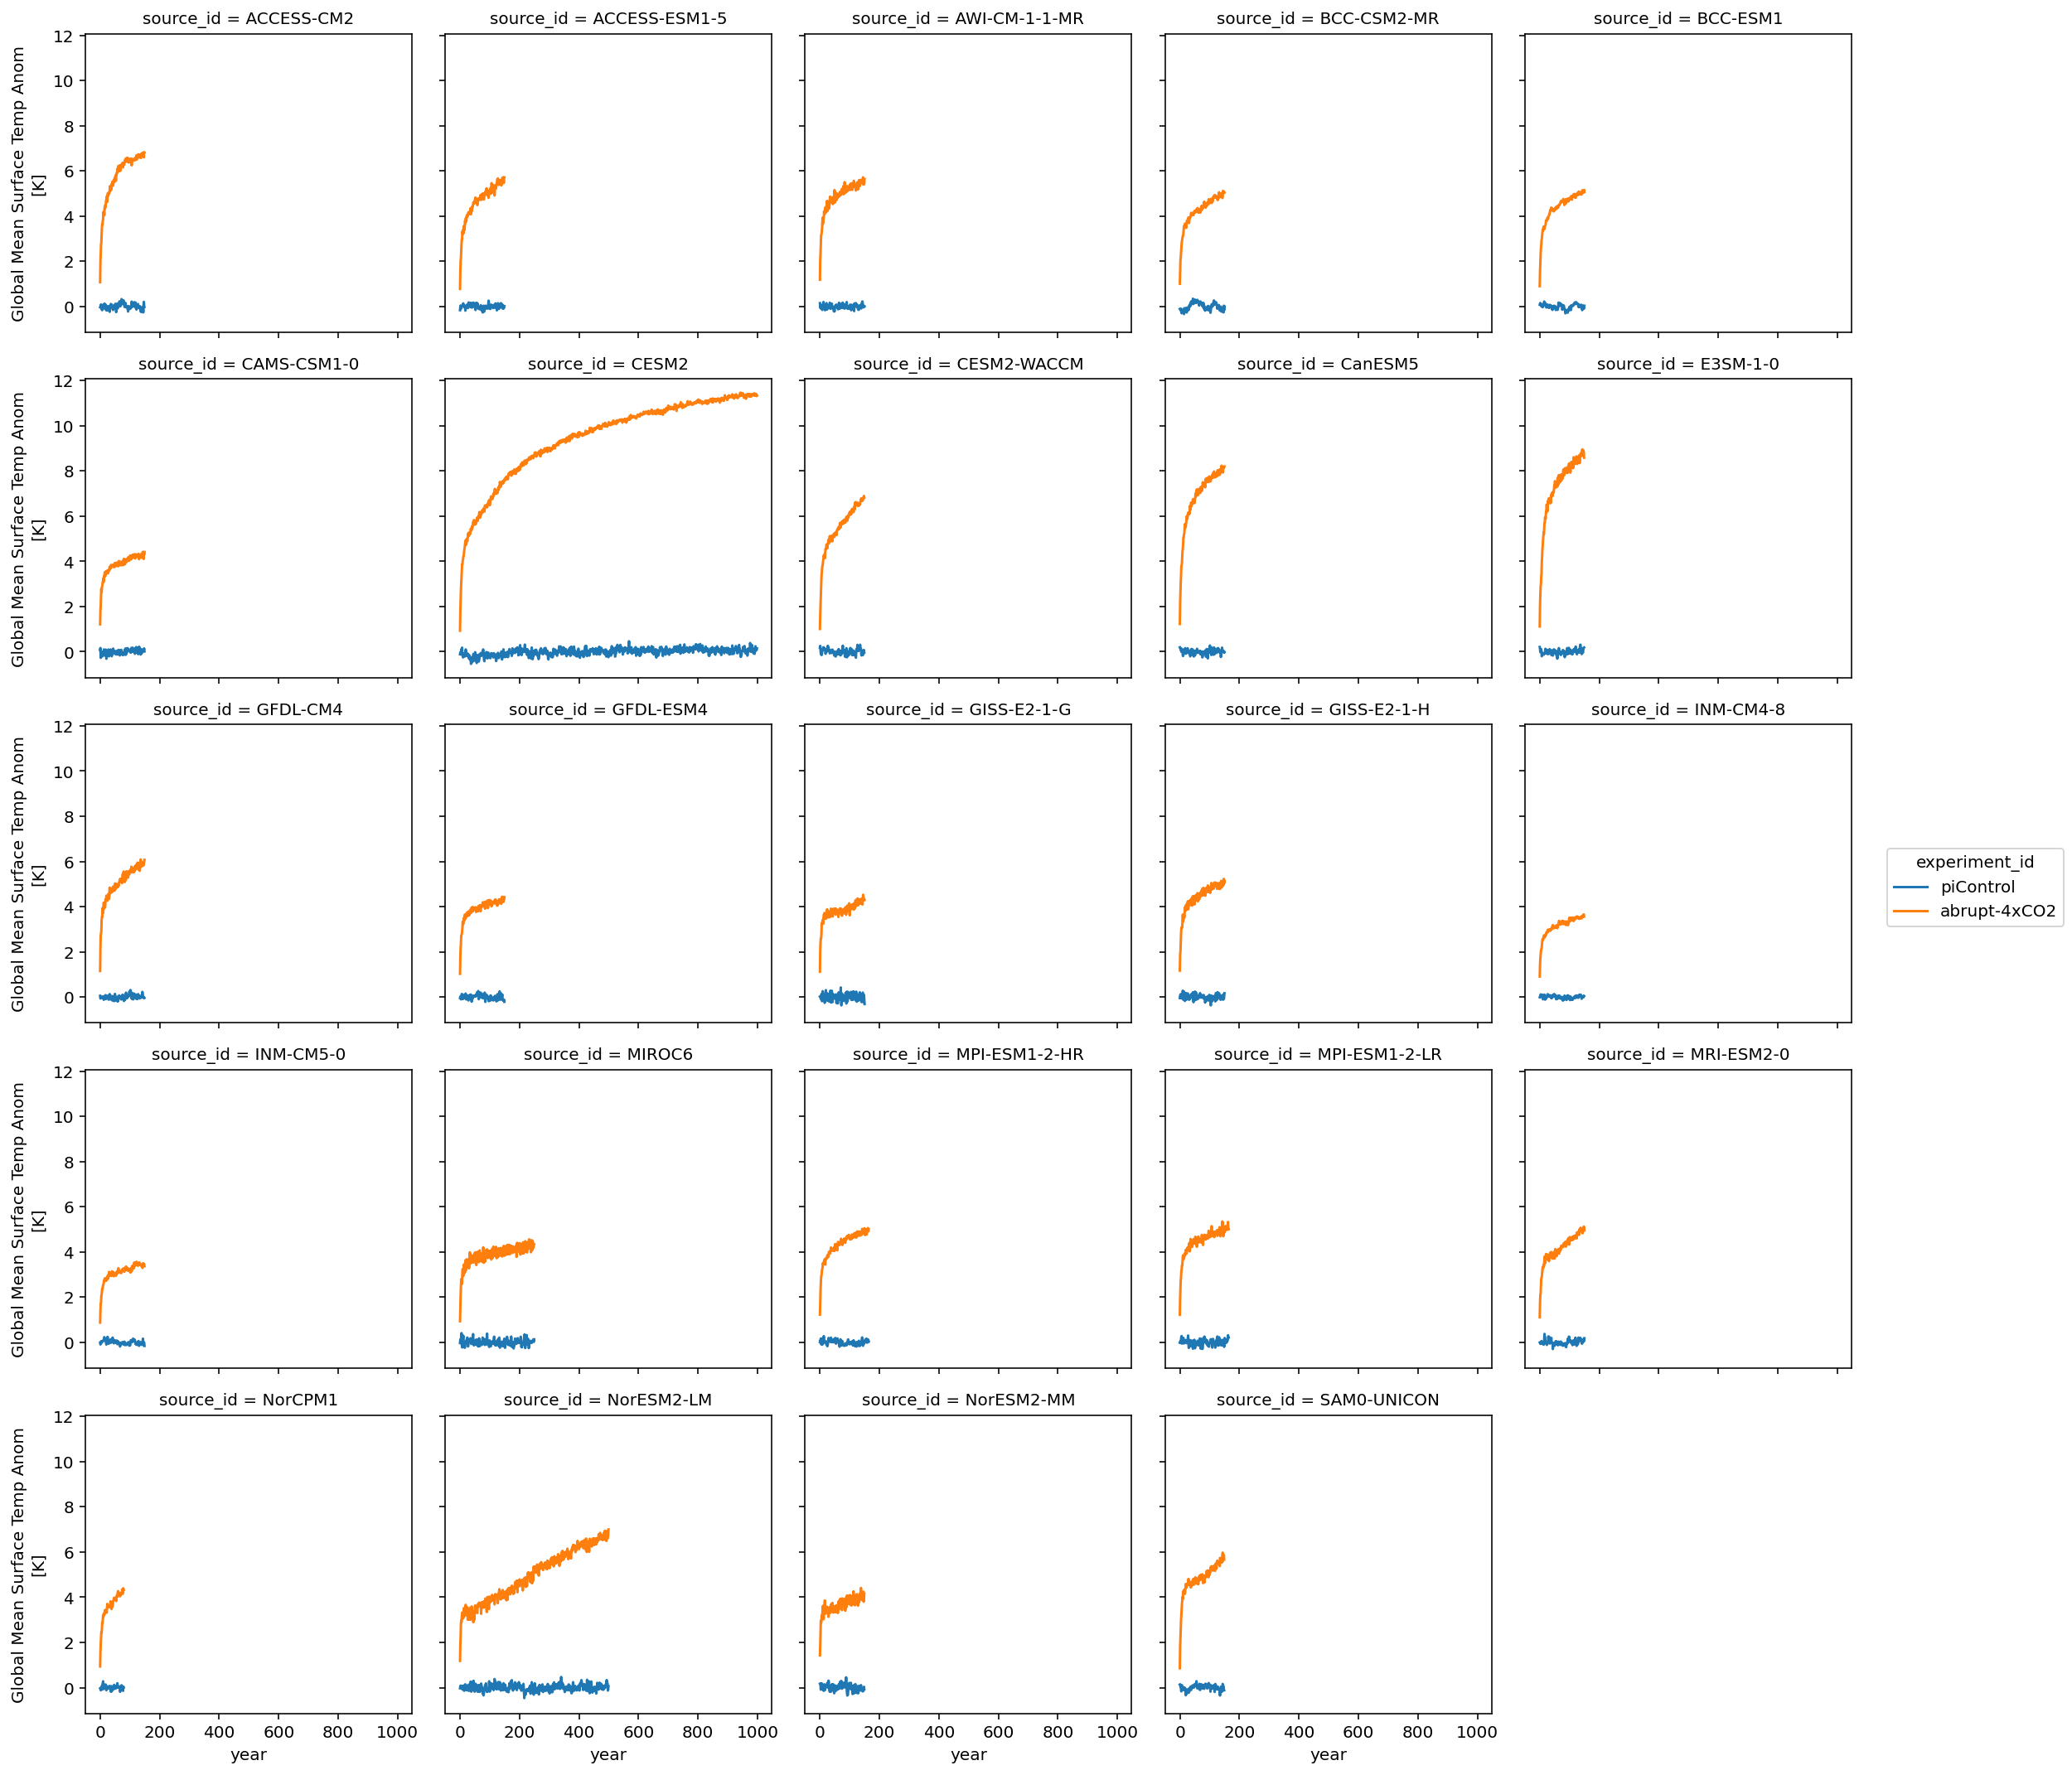

In [16]:
ds_anom.tas.plot.line(col='source_id', x='year', col_wrap=5)

We can see that the models cover different time intervals. Let's limit the rest of our analysis to the first 150 years.

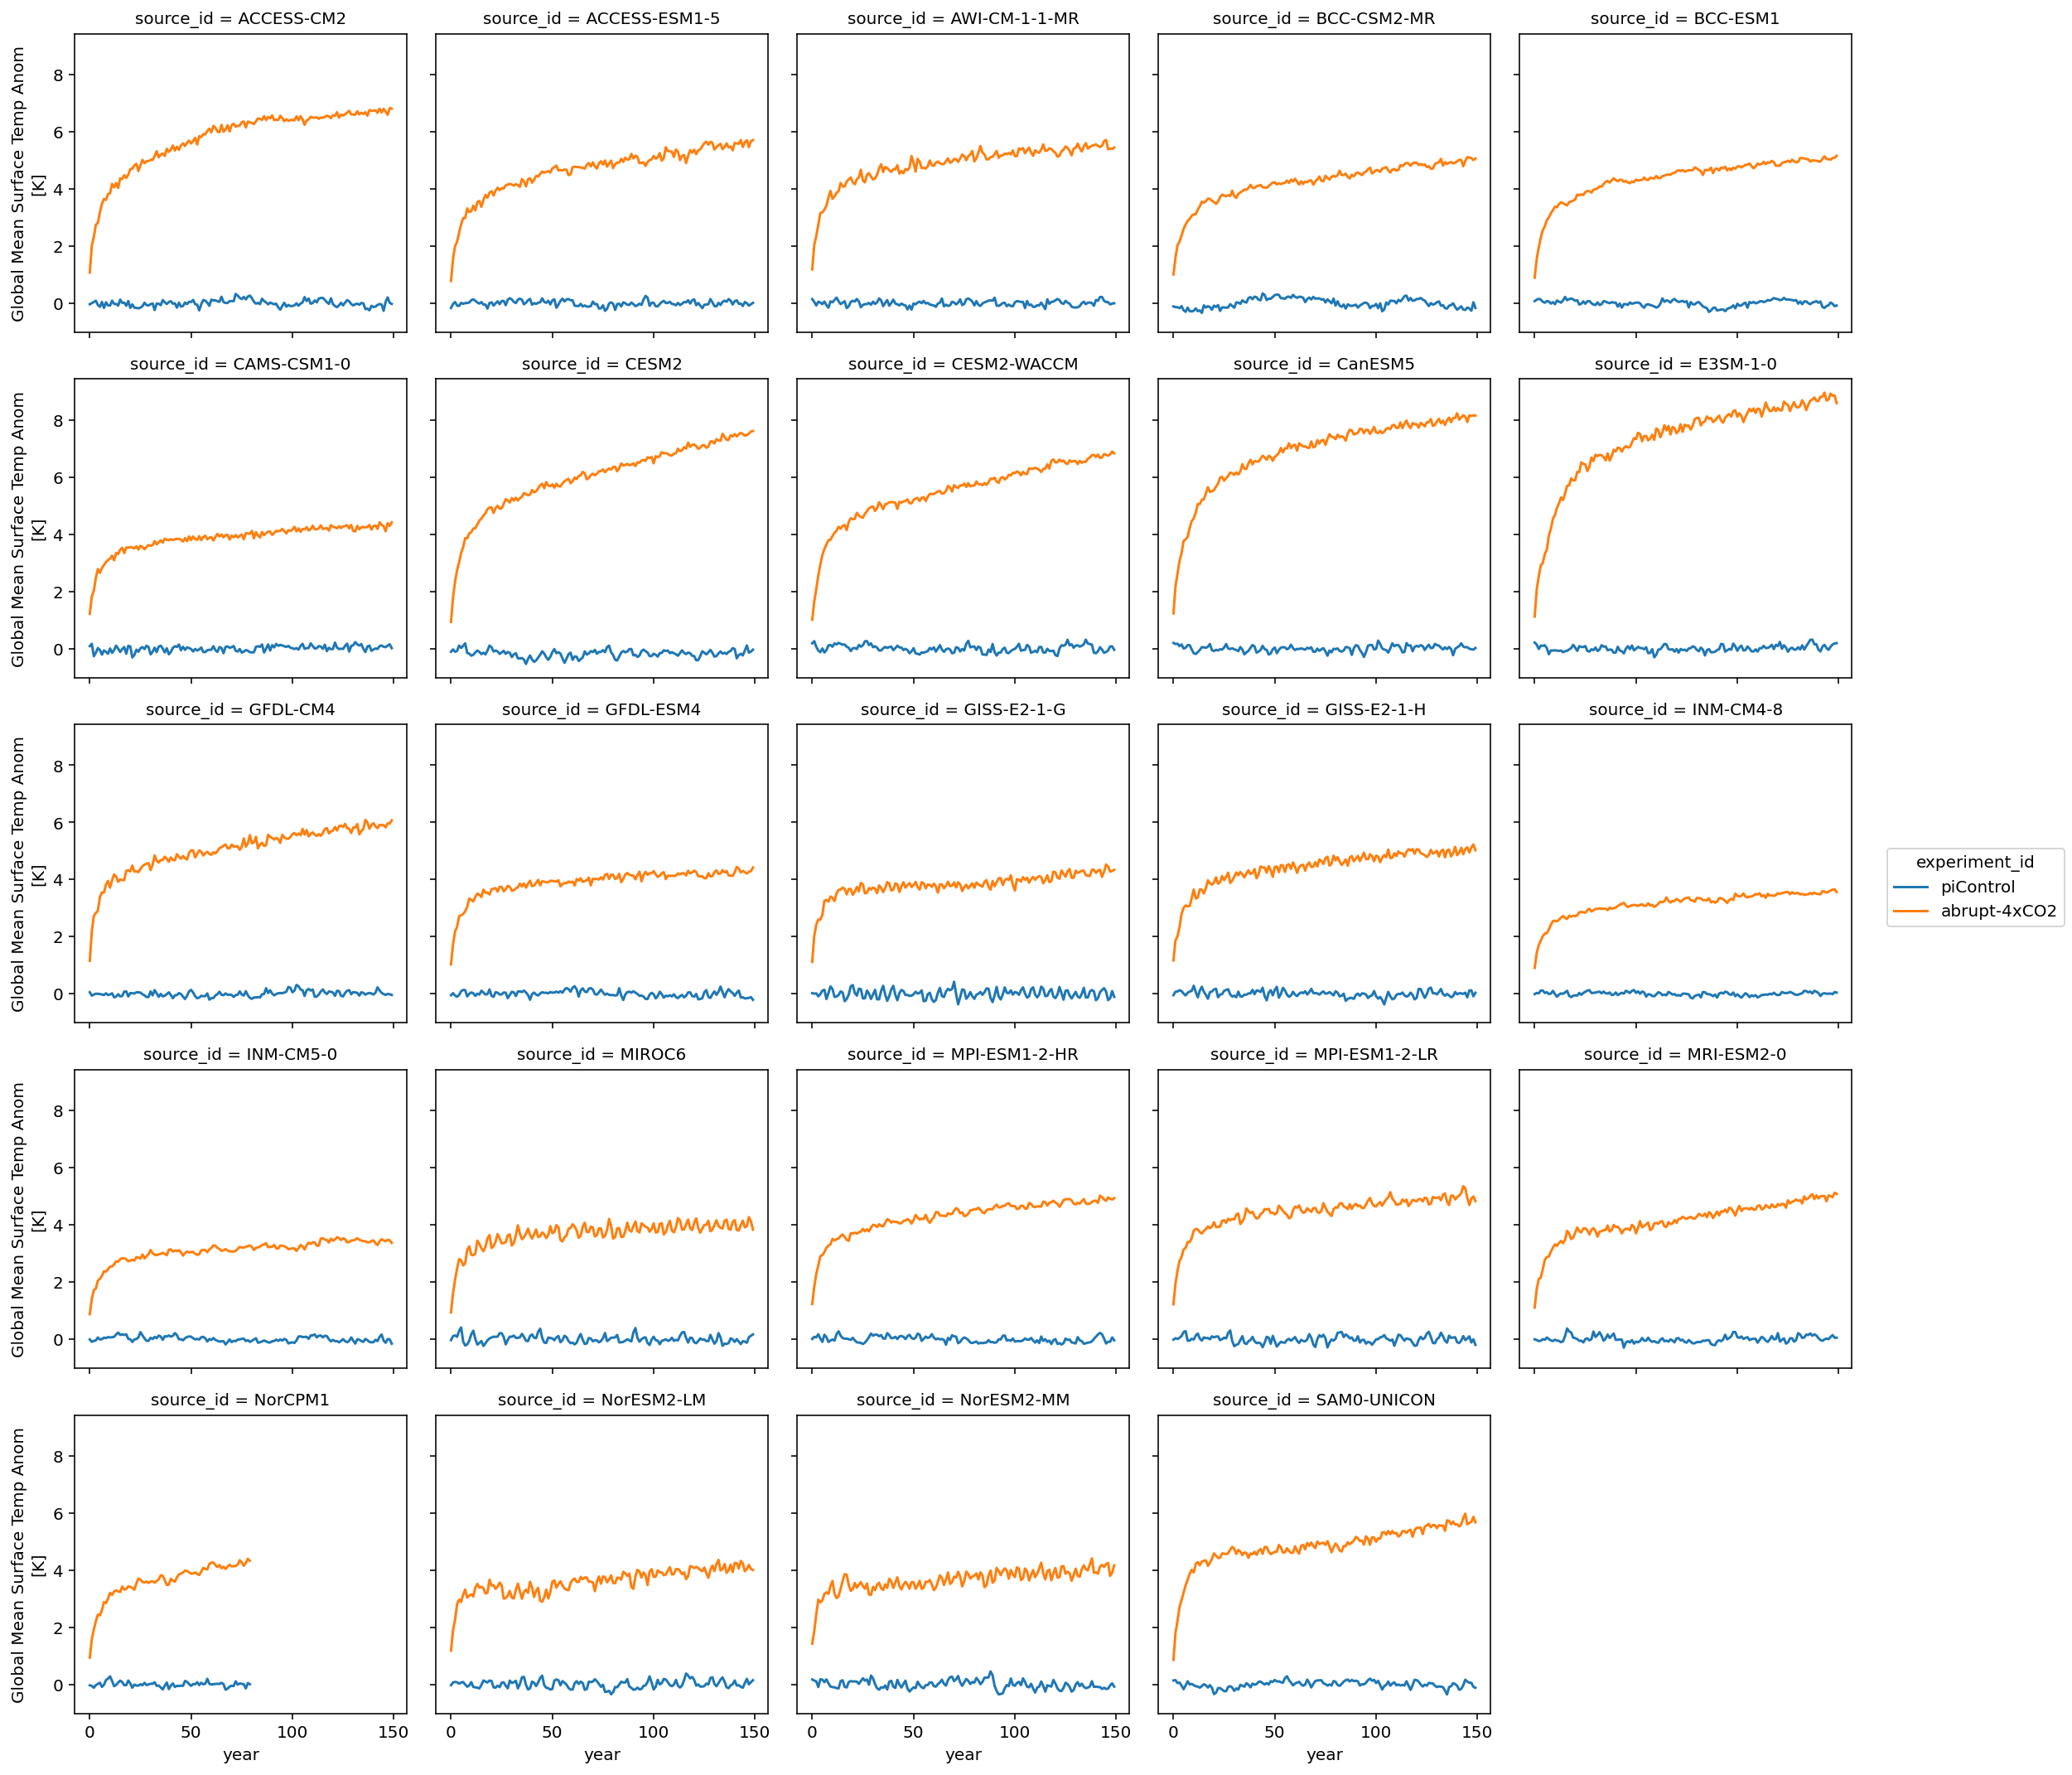

In [17]:
# limit to the gregory 150-year period
first_150_years = slice(0, 149)
ds_anom.tas.sel(year=first_150_years).plot.line(col='source_id', x='year', col_wrap=5)

Same thing for radiative imbalance.

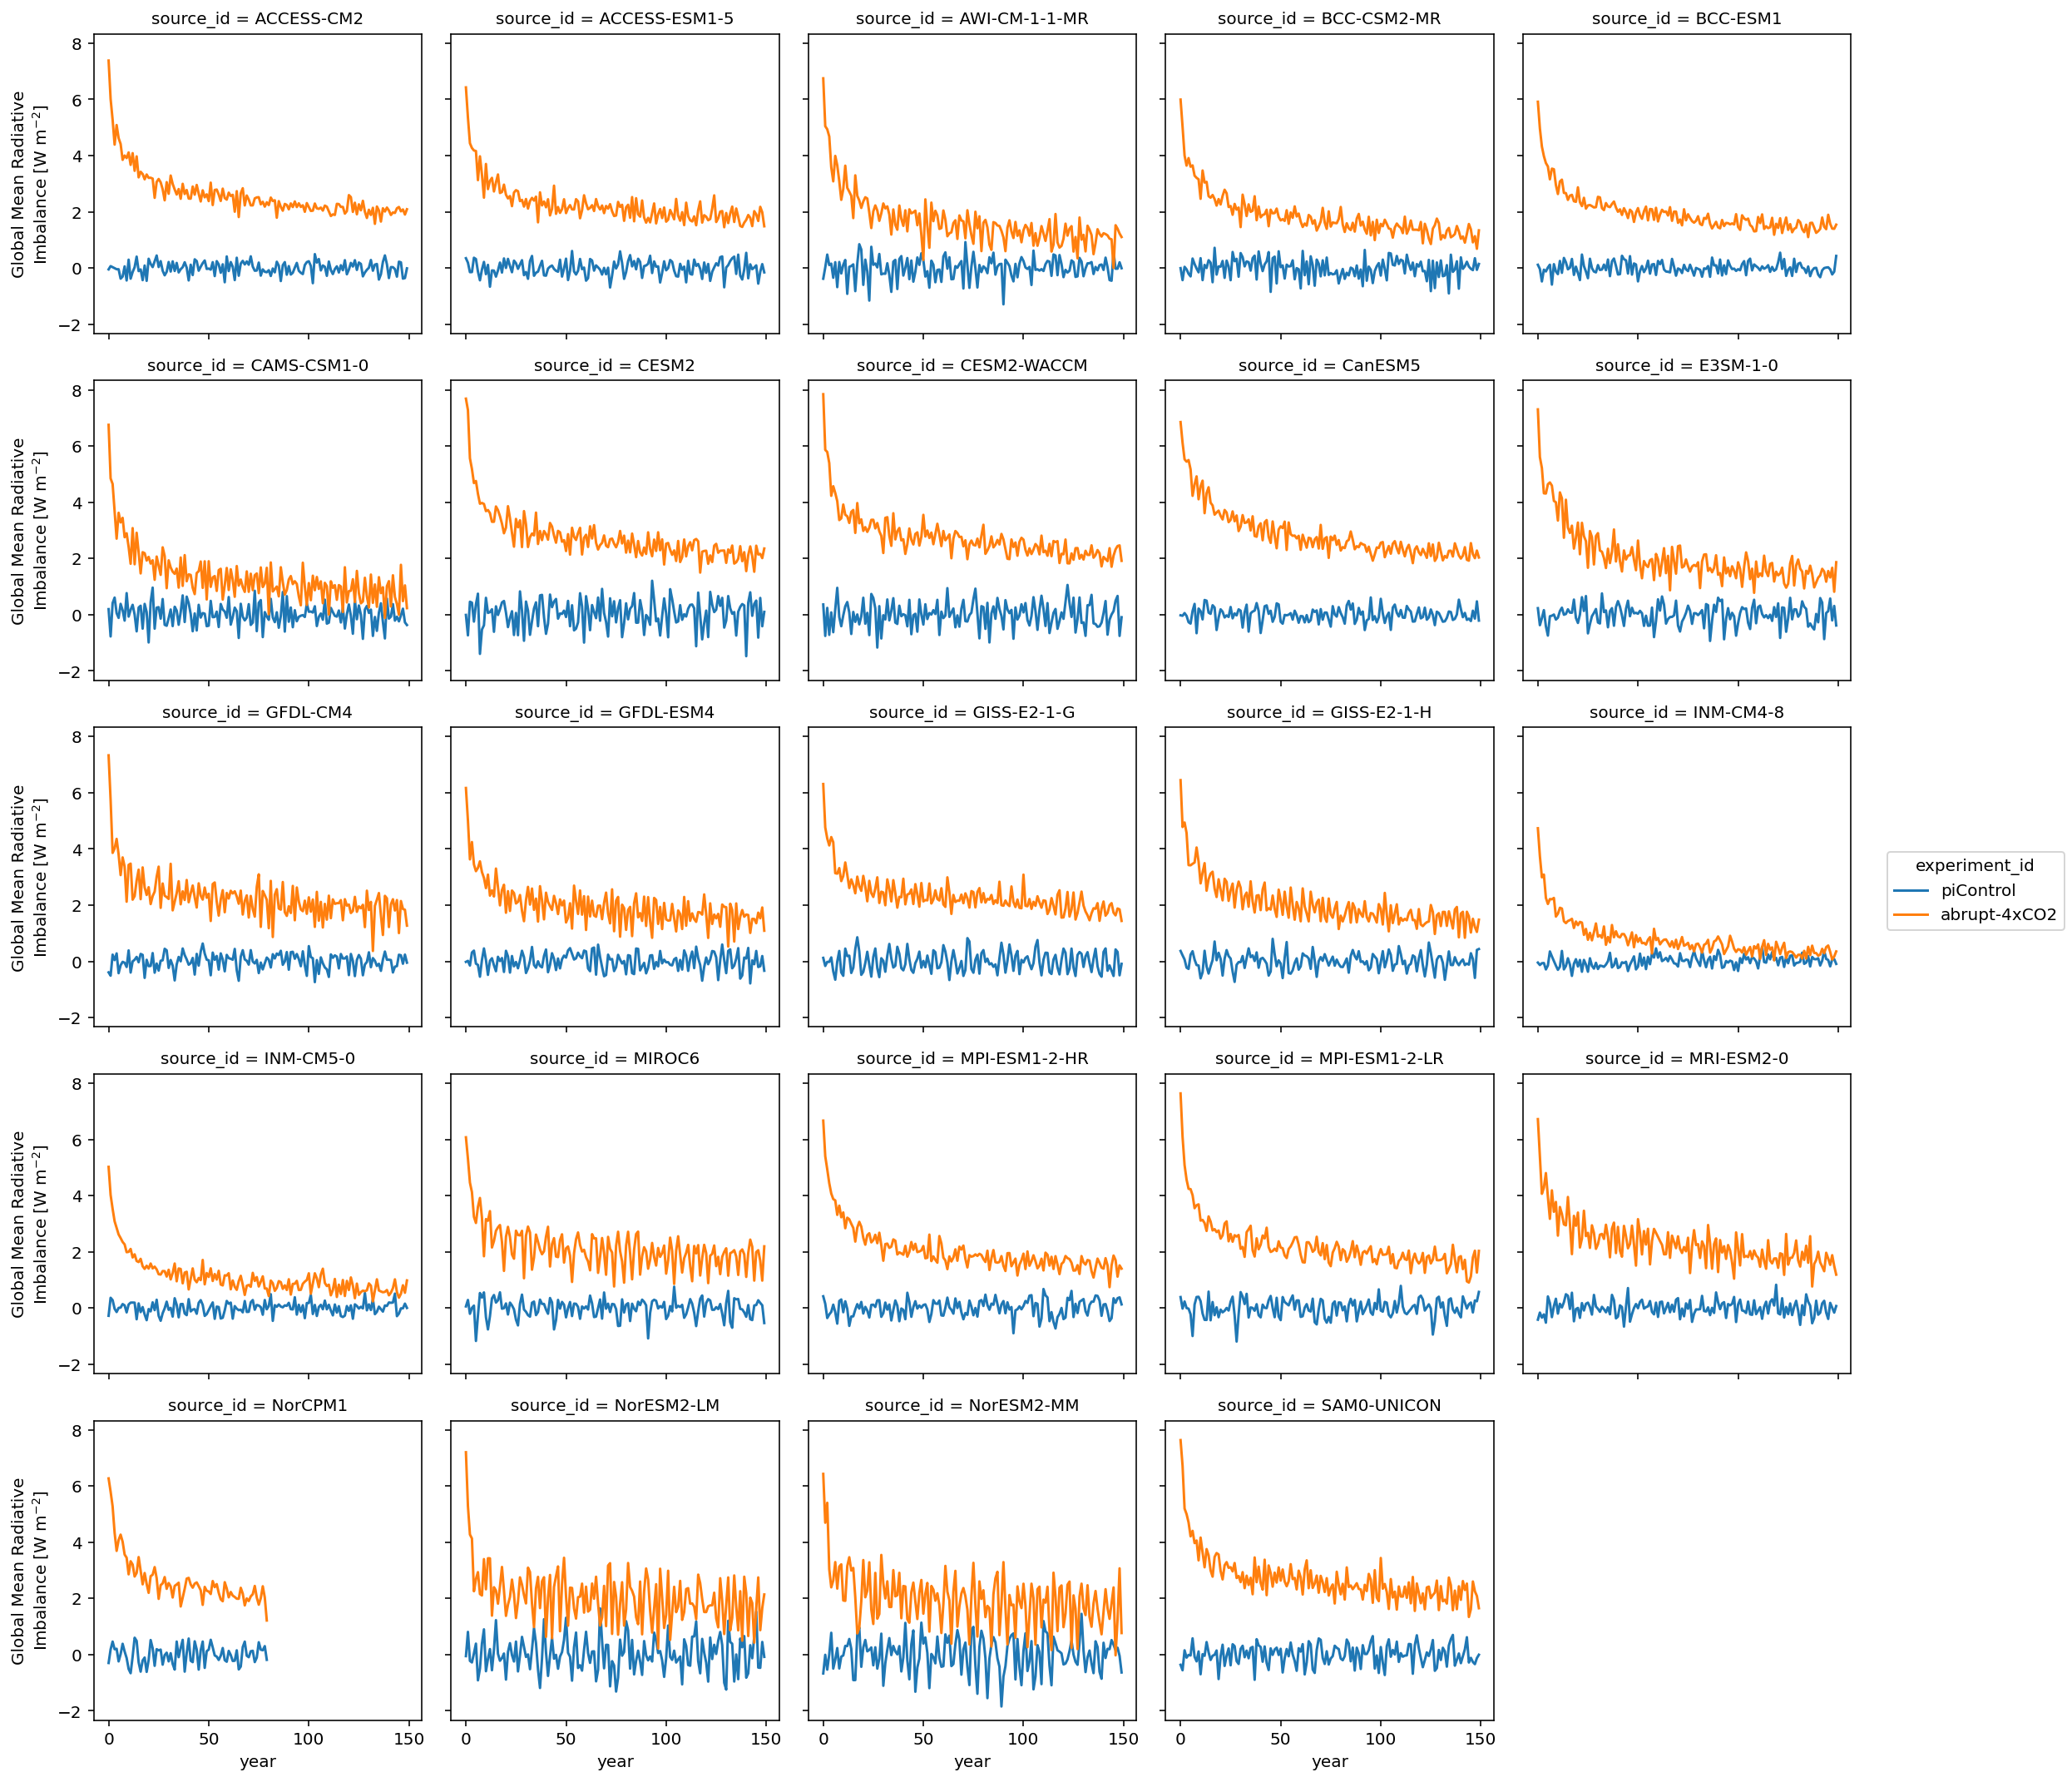

In [18]:
ds_anom.imbalance.sel(year=first_150_years).plot.line(col='source_id', x='year', col_wrap=5)

### Calculate ECS

In [19]:
ds_abrupt = ds_anom.sel(year=first_150_years, experiment_id='abrupt-4xCO2').reset_coords(drop=True)


def calc_ecs(ds):
    # Some sources don't have all 150 years, drop those missing values.
    a, b = np.polyfit(ds.tas.dropna("year"), ds.imbalance.dropna("year"), 1)
    ecs = -0.5 * (b / a)
    return xr.DataArray(ecs)


ds_abrupt['ecs'] = ds_abrupt.groupby('source_id').apply(calc_ecs)
ds_abrupt

<xarray.Dataset>
Dimensions:    (source_id: 24, year: 150)
Coordinates:
  * source_id  (source_id) object 'ACCESS-CM2' 'ACCESS-ESM1-5' ... 'SAM0-UNICON'
  * year       (year) float64 0.0 1.0 2.0 3.0 4.0 ... 146.0 147.0 148.0 149.0
Data variables:
    tas        (source_id, year) float64 1.071 2.014 2.323 ... 5.684 5.863 5.674
    imbalance  (source_id, year) float64 7.382 6.014 5.277 ... 2.254 2.088 1.652
    ecs        (source_id) float64 4.728 3.861 3.124 3.021 ... 2.58 2.445 3.678

Reproduce a plot similar to [Mark Zelinka's](https://twitter.com/mzelinka/status/1255534531144085513):

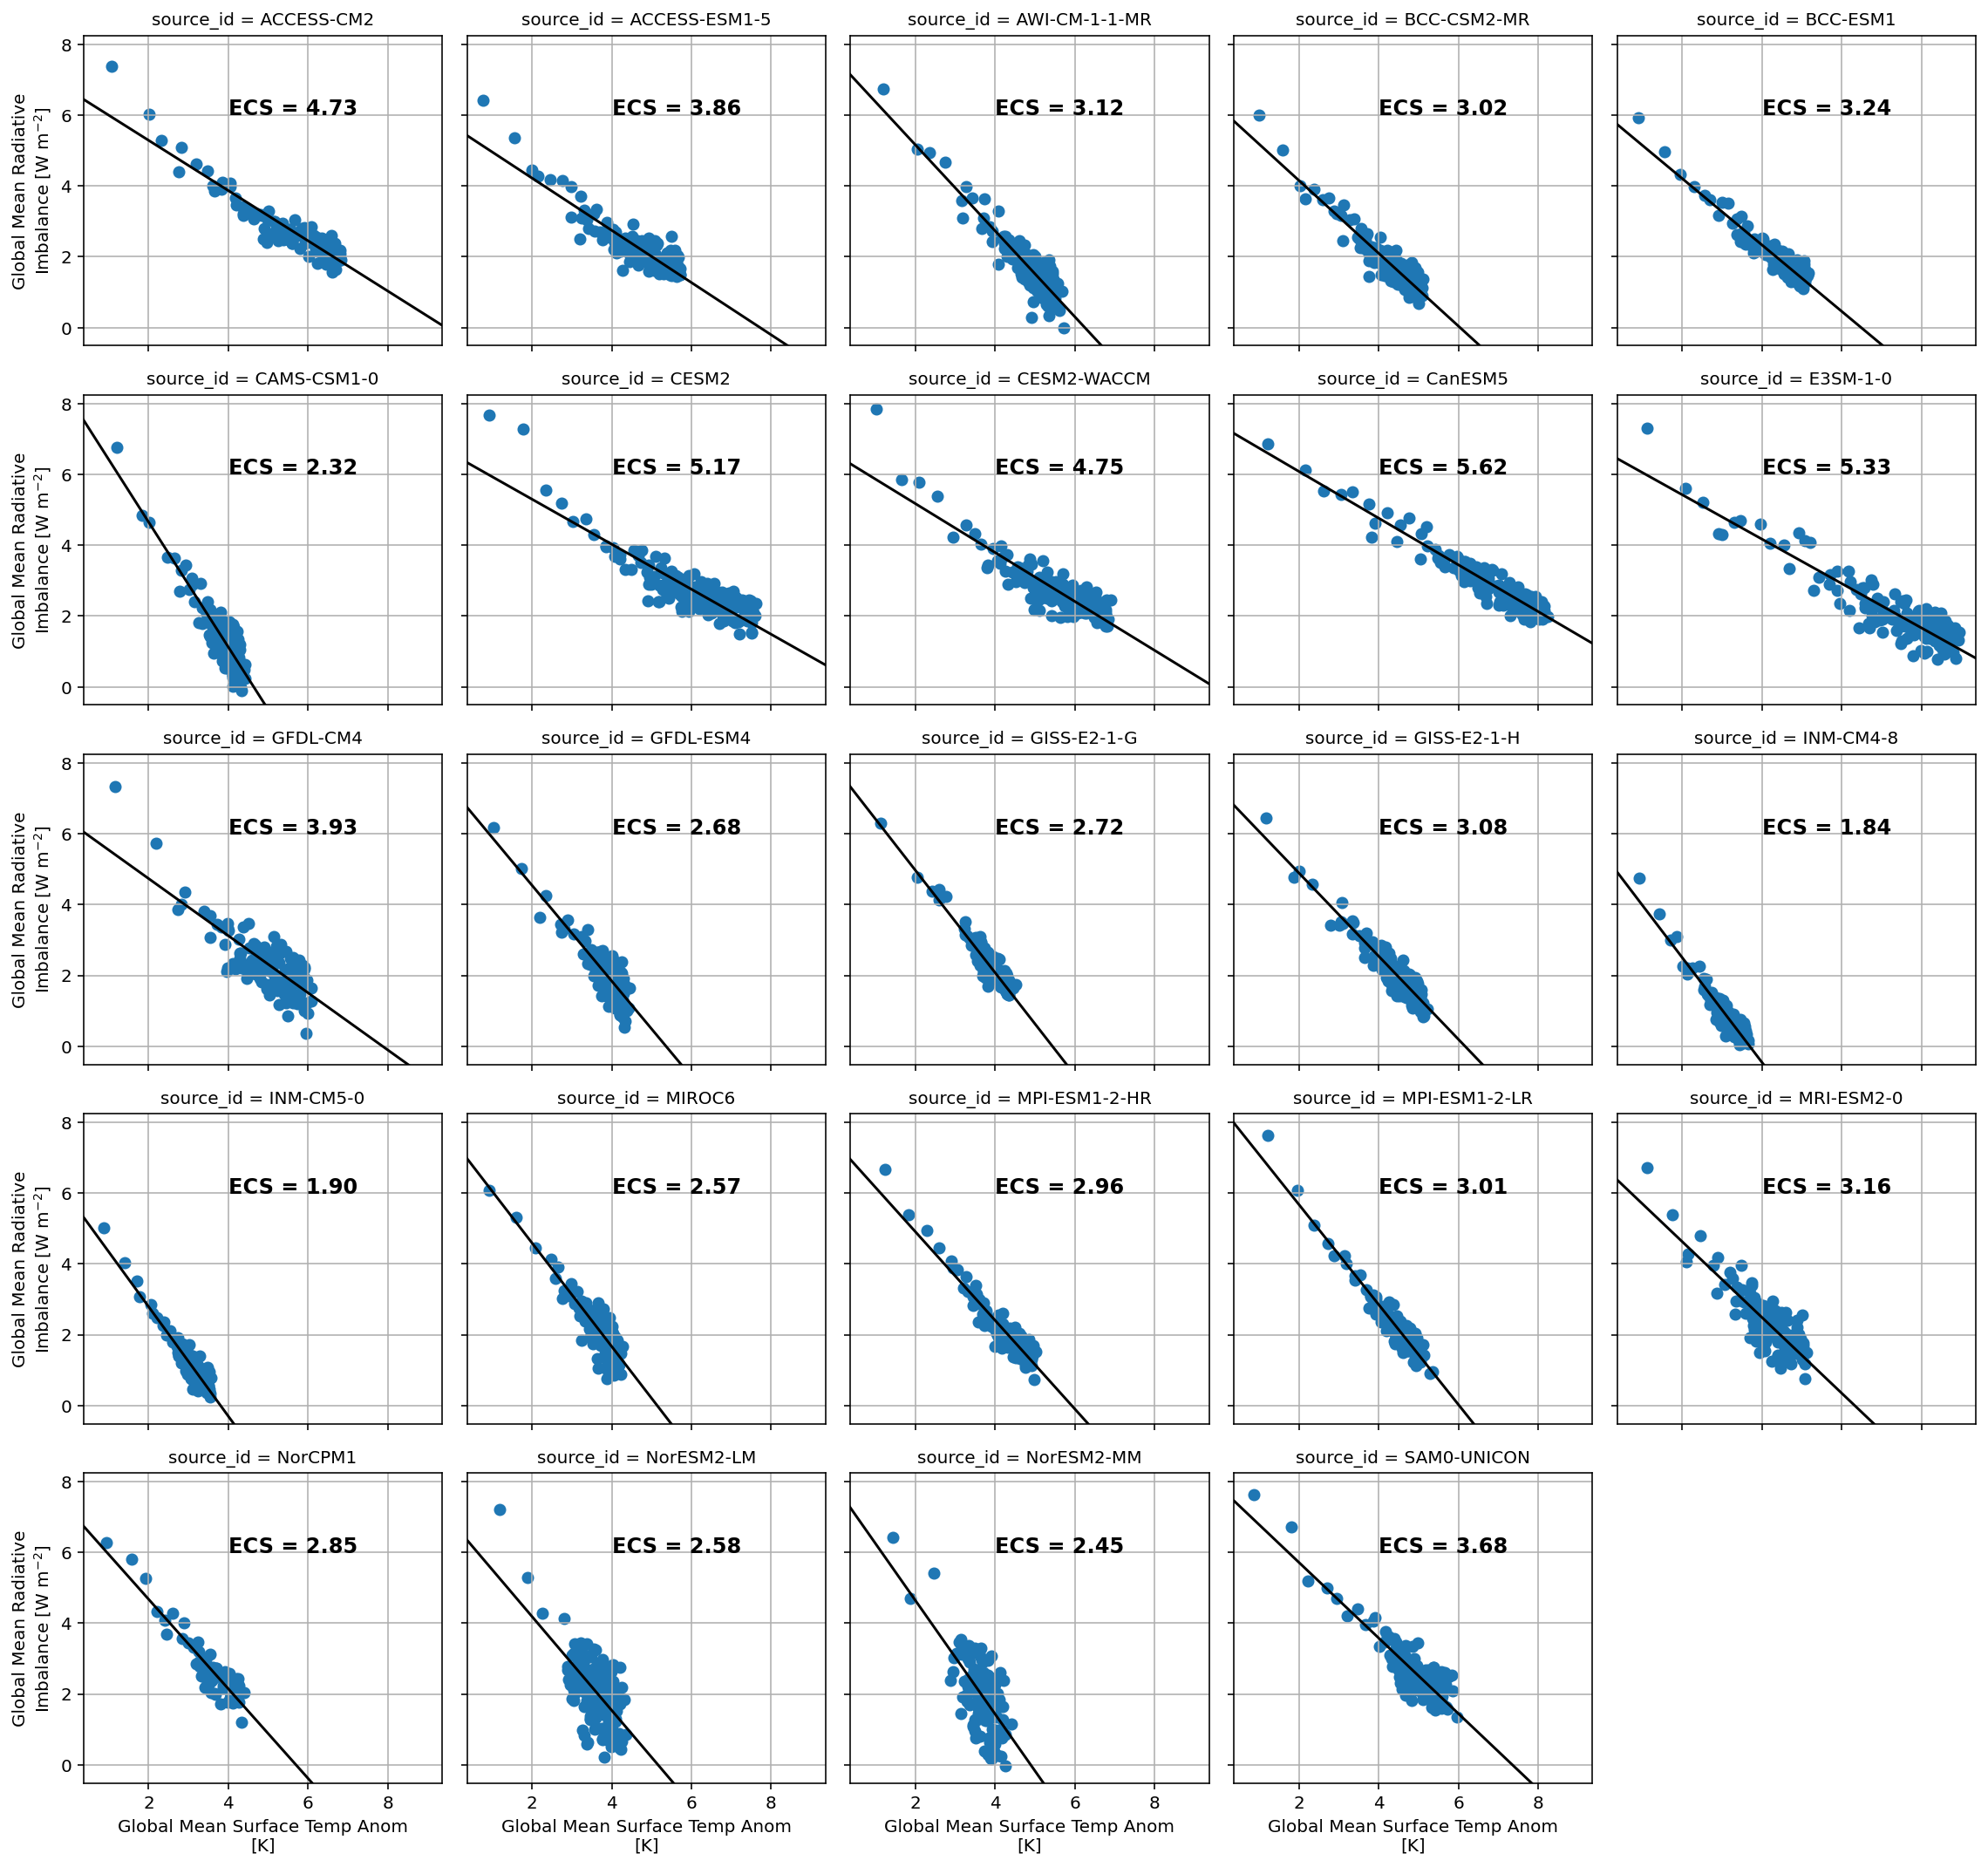

In [20]:
fg = ds_abrupt.plot.scatter(x='tas', y='imbalance', col='source_id', col_wrap=5)


def calc_and_plot_ecs(x, y, **kwargs):
    x = x[~np.isnan(x)]
    y = y[~np.isnan(y)]
    a, b = np.polyfit(x, y, 1)
    ecs = -0.5 * b / a
    plt.autoscale(False)
    plt.plot([0, 10], np.polyval([a, b], [0, 10]), 'k')
    plt.text(4, 6, f'ECS = {ecs:3.2f}', fontdict={'weight': 'bold', 'size': 12})
    plt.grid()


fg.map(calc_and_plot_ecs, 'tas', 'imbalance')

(array([2., 4., 4., 6., 1., 2., 0., 2., 1., 2.]),
 array([1.84413692, 2.22126918, 2.59840145, 2.97553371, 3.35266598,
        3.72979824, 4.1069305 , 4.48406277, 4.86119503, 5.2383273 ,
        5.61545956]),
 <BarContainer object of 10 artists>)

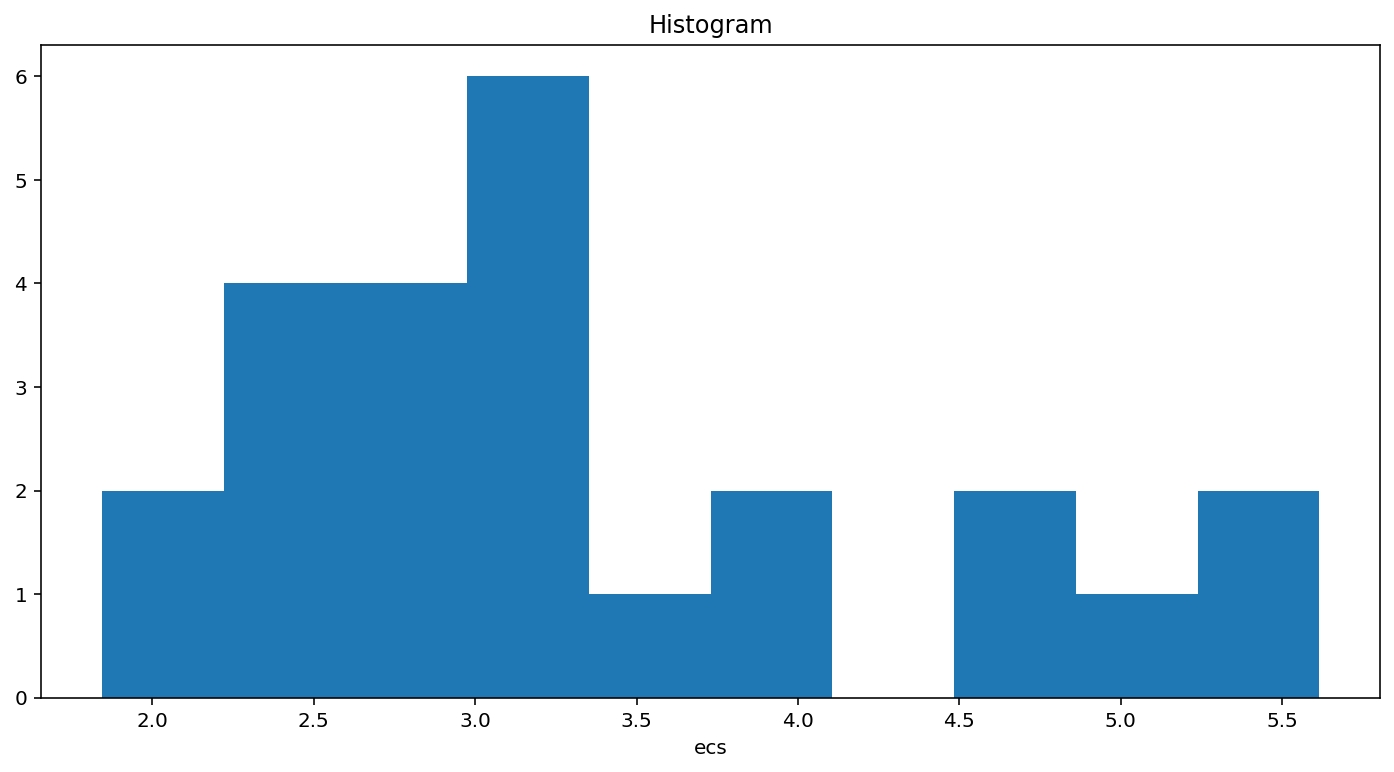

In [21]:
ds_abrupt.ecs.plot.hist();

<AxesSubplot:xlabel='source_id'>

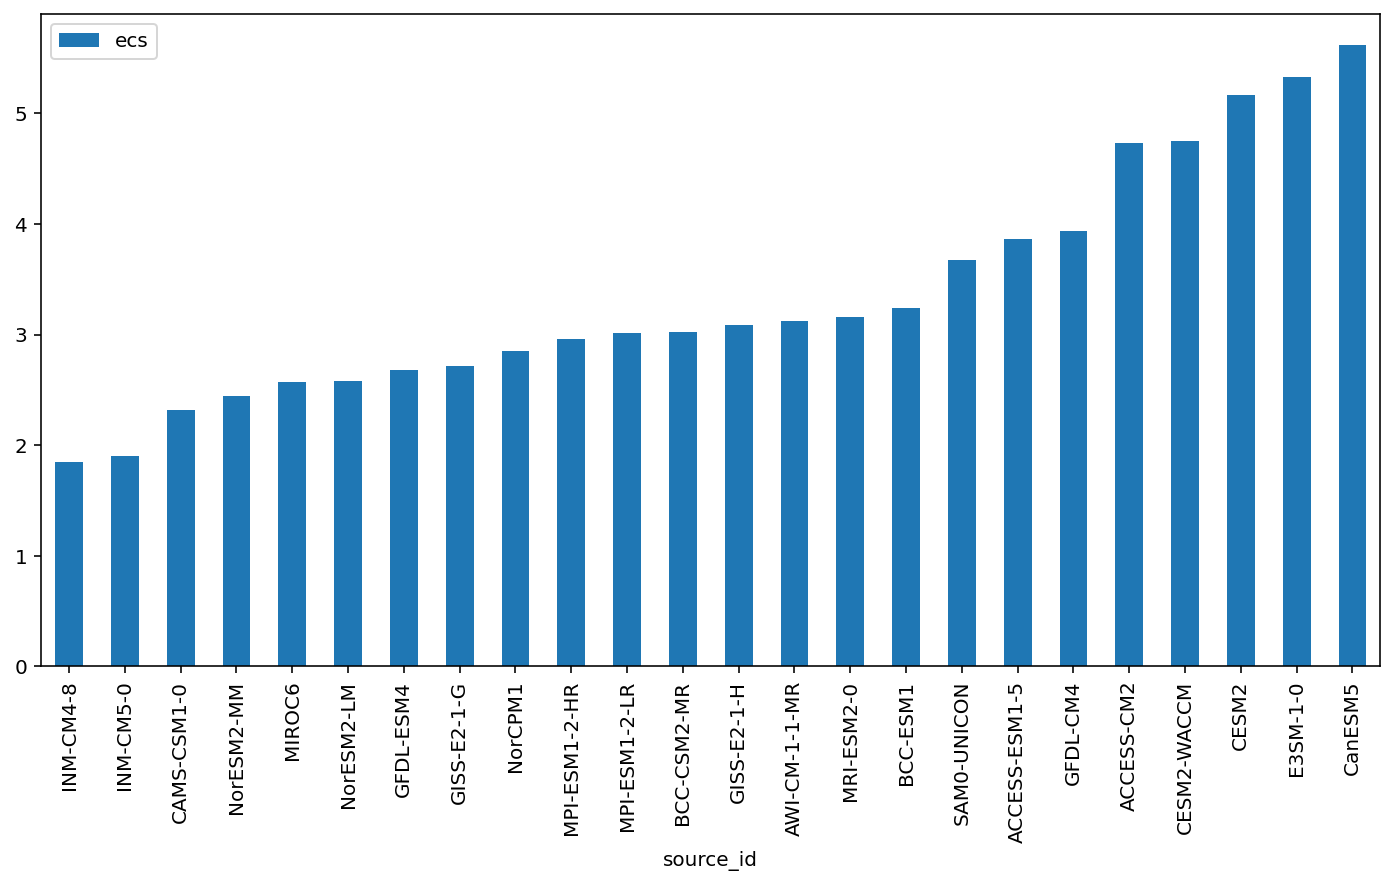

In [22]:
ds_abrupt.ecs.to_dataframe().sort_values('ecs').plot(kind='bar')